<a href="https://colab.research.google.com/github/2ndt2nd/Final-Project-IAT-360/blob/main/Final_Project_Jacques_Seth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1> <b> IAT 360 Final Project <b> </h1></center>

This is the final project for IAT 360
Group Members:
    - Seth van der Zweep (301461888)
    - Jacques Davidson Widodo (301443163)


<h2>Importing required Libraries<h2>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import cv2
import seaborn as sns
import glob
import xml.etree.ElementTree as ET
from PIL import Image
import os
import shutil

from IPython.display import display, Javascript, clear_output
from base64 import b64decode
from PIL import Image

2024-11-27 15:57:23.192844: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-27 15:57:23.227621: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732751843.268427     379 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732751843.280894     379 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-27 15:57:23.320147: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

<strong>Import Ultralytics<strong>


In [1]:
import ultralytics
ultralytics.checks()

from ultralytics import YOLO

model = YOLO('best.pt')

Ultralytics 8.3.38 🚀 Python-3.12.7 torch-2.5.1+cu124 CPU (11th Gen Intel Core(TM) i5-1135G7 2.40GHz)
Setup complete ✅ (8 CPUs, 19.3 GB RAM, 0.0/9.7 GB disk)


<h1>Process Feed<h1>

In [2]:
import cv2

cap = cv2.VideoCapture(0)  # Try different indices like 0, 1, 2
if not cap.isOpened():
    print("Error: Could not open webcam.")
else:
    print("Webcam opened successfully!")
    
cap.release()


Webcam opened successfully!


In [30]:
# Function to process the video feed
def process_video_feed(model):
    """
    Capture and display video from the webcam.
    Gesture detection logic will be added later.
    """
    #cap = cv2.VideoCapture(0)  # Open webcam
    cap = cv2.VideoCapture(0, cv2.CAP_V4L2)  # Adjust backend for your OS
    cap.set(cv2.CAP_PROP_FPS, 60)  # Request 30 FPS

    if not cap.isOpened():
        print("Error: Could not open webcam.")
        return
    
    while True:
        ret, frame = cap.read()  # Capture each frame
        
        if not ret:
            print("Error: Failed to grab frame.")
            break
        
        # Use YOLO model to detect objects/gestures in the frame
        results = model(frame)  # Perform inference on the current frame
        
        # Results contains the detected objects; we need to render them
        # Access the first result in the list and render it
        rendered_frame = results[0].plot()  # 'plot' renders the frame with detections

        # Display the frame with rendered bounding boxes
        cv2.imshow("Webcam Feed", rendered_frame)
        
        # Gesture detection and vending machine control logic will go here
        
        # Exit the loop when 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    cap.release()  # Release the webcam
    cv2.destroyAllWindows()  # Close OpenCV windows


In [31]:
# Start processing the webcam feed
process_video_feed(model)



0: 480x640 (no detections), 461.9ms
Speed: 3.2ms preprocess, 461.9ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 649.1ms
Speed: 23.5ms preprocess, 649.1ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 547.0ms
Speed: 5.9ms preprocess, 547.0ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 455.8ms
Speed: 4.8ms preprocess, 455.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 547.4ms
Speed: 8.9ms preprocess, 547.4ms inference, 3.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 542.7ms
Speed: 20.3ms preprocess, 542.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 483.5ms
Speed: 17.0ms preprocess, 483.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 561.0ms
Speed: 9.4ms pr

In [7]:
    cap.release()  # Release the webcam
    cv2.destroyAllWindows()  # Close OpenCV windows

<strong>Core Code<strong>

In [5]:
while True:
    # Capture a frame from the webcam
    ret, frame = cap.read()
    if not ret:
        print("Failed to grab frame")
        break

    # Perform YOLO inference on the frame
    results = model(frame)

    # Visualize detections
    annotated_frame = results[0].plot()  # YOLOv8's method to plot results on the frame

    # Show the frame with detections
    cv2.imshow("YOLO Gesture Recognition", annotated_frame)

    # Break loop on pressing 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

NameError: name 'model' is not defined

<strong>Release Cam<strong>

In [ ]:
cap.release()
cv2.destroyAllWindows()

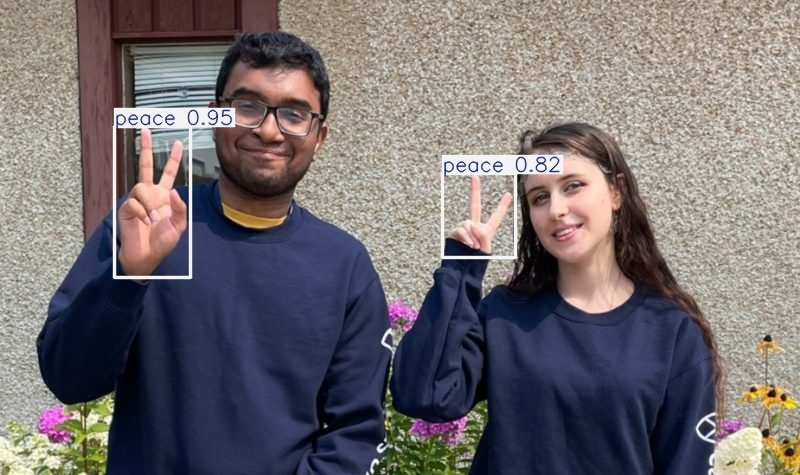

In [ ]:
# SHOW THE IMAGE STORED
%matplotlib inline
from PIL import Image

Image.open('/content/runs/detect/predict/close-up-version-1-qb0g0fi6m737kdhsqwyd9sa6w5oc6iw75suqyyf6vi.jpg')